# 15.프로젝트: Movielens 영화 추천
##### !. Aiffel jupyter cloud 플랫폼에서 작성되었습니다.


---

## 목차
- STEP 0. 주요 라이브러리 import. 
- STEP 1. 데이터 준비와 전처리
- STEP 2. 분석해 봅시다.
- STEP 3. 내가 선호하는 영화를 5가지 골라서 ratings에 추가해 줍시다.
- STEP 4. CSR matrix를 직접 만들어 봅시다.
- STEP 5. als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시켜 봅시다.
- STEP 6. 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요.
- STEP 7. 내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다.
- STEP 8. 내가 가장 좋아할 만한 영화들을 추천받아 봅시다.  
- 회고록   
- Reference

---

### (서론)

MF 모델 학습 방법을 토대로, 내가 좋아할 만한 영화 추천 시스템을 제작한다.
이번 프로젝트에서 활용한 데아터셋은 추천 시스템의 MNIST라고 부를만한 Movielens 데이터이다.

#### 특이점.
* 유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기 별로 있음. `MovieLens lm Dataset` 사용.
* 별점 데이터는 대표적인 explicit 데이터. 하지만 implicit 데이터로 간주하고 테스트를 진행.
* 별점을 시청횟수로 해석해서 진.
* 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외.

---

### (본문)

### STEP 0. 주요 라이브러리 import

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

### STEP 1. 데이터 준비와 전처리

#### 1. 기본 데이터(평점) 불러오기: Movielens 데이터 `rating.dat` 
- 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 깔끔하게 정리되어 있다.

#### 데이터 특성.
(UserID::MovieID::Rating::Timestamp)
- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

- Pandas를 활용해 데이터를 열고, ratings_cols라는 컬럼명을 생성해 지정.

In [4]:
rating_file_path='/aiffel/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


- 원본 기본 데이터 보관

In [5]:
ratings_orig = ratings.copy()
ratings_orig_size = len(ratings)
print(ratings_orig_size)

1000209


- 유저별 컬럼에 대한 통계 확인

In [6]:
# 유저별 몇 개의 영화를 보고 있는지에 대한 통계
user_count_orig = ratings_orig.groupby('user_id')['movie_id'].count()
user_count_orig.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
Name: movie_id, dtype: float64

In [7]:
# 유저별 시청횟수 중앙값에 대한 통계
user_median_orig = ratings_orig.groupby('user_id')['ratings'].median()
user_median_orig.describe()

count    6040.000000
mean        3.840811
std         0.577449
min         1.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: ratings, dtype: float64

- 별점 개수(ratings)와 사용자 수(users) 관계 막대그래프

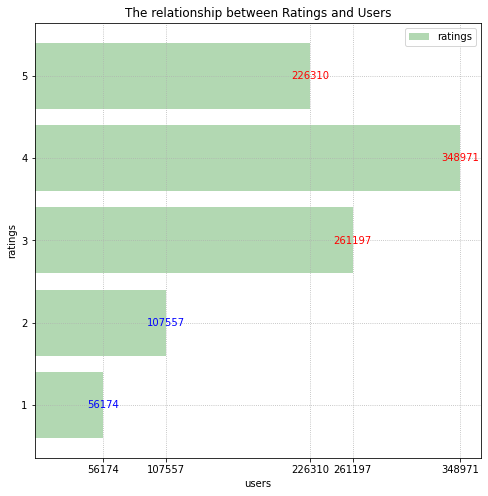

In [8]:
ratings_users = ratings.groupby(by=['ratings']).agg({'user_id': 'count'}).reset_index()
ratings_users.columns = ['ratings', 'users']
ratings_users_dic = {ratings:users for ratings, users in zip(ratings_users.ratings, ratings_users.users)}

plt.figure(figsize=(8,8))
plt.barh(ratings_users.ratings, ratings_users.users, align='center', alpha=0.3, color='g')
plt.yticks(ratings_users.ratings)
plt.xticks(ratings_users.users)
plt.legend(ratings_users.columns)
plt.ylabel('ratings')
plt.xlabel('users')
plt.grid(ls='dotted')
plt.title('The relationship between Ratings and Users')

for i, users in enumerate(ratings_users.users):
    if i >= 2:
        color = 'r'
    else:
        color = 'b'
    plt.text(users+i,1+i,users, horizontalalignment='center', verticalalignment='center', color=color)

plt.show()

- 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외

In [9]:
# 3점 이상만 남김.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [12]:
# ratings 컬럼의 이름을 counts로 바꿈.
ratings.rename(columns={'ratings':'counts'}, inplace=True)
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

- 유저별 컬럼에 대한 통계 확인

In [13]:
# 유저별 몇 개의 영화를 보고 있는지에 대한 통계
user_count = ratings.groupby('user_id')['movie_id'].count()
user_count.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: movie_id, dtype: float64

In [14]:
# 유저별 시청횟수 중앙값에 대한 통계
user_median = ratings.groupby('user_id')['counts'].median()
user_median.describe()

count    6039.000000
mean        4.055970
std         0.432143
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: counts, dtype: float64

- Convert timestamp to datetime with pandas [[참고]](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html)
    - pd.to_datetime(arg, unit='s') => year-month-day hh:mm:ss
        - arg: int, float, str, datetime, list, tuple, 1-d array, Series, DataFrame/dict-like
        - unit: str, default ‘ns’ (D,s,ms,us,ns)

In [15]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings

/tmp/ipykernel_32/2721094061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')


,user_id,movie_id,counts,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
...,...,...,...,...
1000203,6040,1090,3,2000-04-26 02:18:38
1000205,6040,1094,5,2000-04-25 23:21:27
1000206,6040,562,5,2000-04-25 23:19:06
1000207,6040,1096,4,2000-04-26 02:20:48


- 데이터 확인

In [16]:
# 결측치 확인
ratings.isna().sum()

user_id      0
movie_id     0
counts       0
timestamp    0
dtype: int64

In [17]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836478 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    836478 non-null  int64         
 1   movie_id   836478 non-null  int64         
 2   counts     836478 non-null  int64         
 3   timestamp  836478 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 31.9 MB


- 첫 번째 유저가 어떤 영화를 봤는지 확인

In [18]:
ratings_user_1 = (ratings['user_id']==ratings.loc[0, 'user_id'])
movies_user_1 = ratings.loc[ratings_user_1]
print(f'user_1 이 시청한 영화 개수: {len(movies_user_1)}')
movies_user_1

user_1 이 시청한 영화 개수: 53


,user_id,movie_id,counts,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
5,1,1197,3,2000-12-31 22:37:48
6,1,1287,5,2000-12-31 22:33:59
7,1,2804,5,2000-12-31 22:11:59
8,1,594,4,2000-12-31 22:37:48
9,1,919,4,2000-12-31 22:22:48


#### 2. 메타 데이터(영화) 불러오기: Movielens 데이터 `movies.dat` (MovieID::Title::Genres)
- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres: Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western
- Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries
- Movies are mostly entered by hand, so errors and inconsistencies may exist

In [19]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옴.
movie_file_path='/aiffel/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


- 원본 메타 데이터 보관

In [20]:
movies_orig = movies.copy()
movies_orig_size = len(movies)
print(movies_orig_size)

3883


- 데이터 확인

In [21]:
# 결측치 확인
movies.isna().sum()

movie_id    0
title       0
genre       0
dtype: int64

In [22]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genre     3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


- 데이터 합치기 [[참고1]](https://yganalyst.github.io/data_handling/Pd_12/) [[참고2]](https://www.delftstack.com/ko/howto/python-pandas/pandas-groupby-count-python/)

In [23]:
# ratings 와 movies 데이터 프레임 합치기
ratings = ratings.join(movies.set_index('movie_id'), on='movie_id')
ratings.head(10)

,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,2000-12-31 22:12:40,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,2000-12-31 22:35:09,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,2000-12-31 22:32:48,My Fair Lady (1964),Musical|Romance
3,1,3408,4,2000-12-31 22:04:35,Erin Brockovich (2000),Drama
4,1,2355,5,2001-01-06 23:38:11,"Bug's Life, A (1998)",Animation|Children's|Comedy
5,1,1197,3,2000-12-31 22:37:48,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance
6,1,1287,5,2000-12-31 22:33:59,Ben-Hur (1959),Action|Adventure|Drama
7,1,2804,5,2000-12-31 22:11:59,"Christmas Story, A (1983)",Comedy|Drama
8,1,594,4,2000-12-31 22:37:48,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical
9,1,919,4,2000-12-31 22:22:48,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical


- 첫 번째 유저(user_id == 1)가 시청한 영화 정보 확인

In [24]:
movies_detail_user_1 = ratings[ratings['user_id']==1]
print(f'user_1 이 시청한 영화 개수: {len(movies_detail_user_1)}')
movies_detail_user_1

user_1 이 시청한 영화 개수: 53


,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,2000-12-31 22:12:40,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,2000-12-31 22:35:09,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,2000-12-31 22:32:48,My Fair Lady (1964),Musical|Romance
3,1,3408,4,2000-12-31 22:04:35,Erin Brockovich (2000),Drama
4,1,2355,5,2001-01-06 23:38:11,"Bug's Life, A (1998)",Animation|Children's|Comedy
5,1,1197,3,2000-12-31 22:37:48,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance
6,1,1287,5,2000-12-31 22:33:59,Ben-Hur (1959),Action|Adventure|Drama
7,1,2804,5,2000-12-31 22:11:59,"Christmas Story, A (1983)",Comedy|Drama
8,1,594,4,2000-12-31 22:37:48,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical
9,1,919,4,2000-12-31 22:22:48,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical


- 유저별 시청 영화 개수 그래프

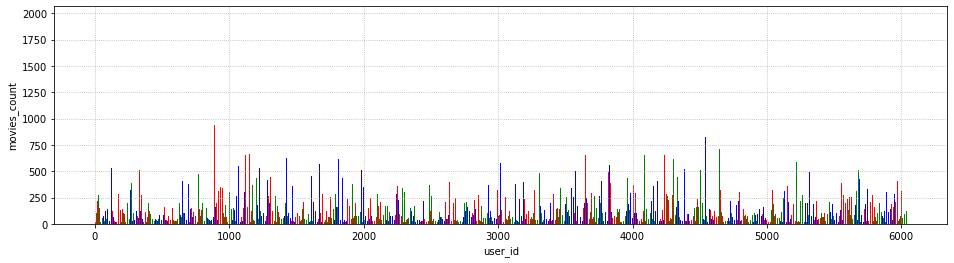

In [25]:
user_counts = ratings.groupby(by=['user_id']).agg({'movie_id': 'count'}).reset_index()
user_counts.columns = ['user_id', 'movies_count']

plt.figure(figsize=(16,4))
plt.bar(user_counts.user_id, user_counts.movies_count, color=['r','g','b'])
plt.xlabel('user_id')
plt.ylabel('movies_count')
plt.grid(ls='dotted')
plt.show()

In [26]:
top_30 = user_counts.sort_values(by=['movies_count'], ascending=False).head(30)
top_30

,user_id,movies_count
4167,4169,1968
4275,4277,1715
1679,1680,1515
3616,3618,1146
1014,1015,1145
5829,5831,1136
2908,2909,1119
1940,1941,1116
423,424,1106
1979,1980,1054


In [27]:
bottom_30 = user_counts.sort_values(by=['movies_count'], ascending=True).head(30)
bottom_30

,user_id,movies_count
4484,4486,1
4347,4349,7
4634,4636,9
4363,4365,9
1101,1102,9
4054,4056,9
940,941,10
5848,5850,11
5826,5828,11
3640,3642,11


### STEP 2. 분석해 봅시다.
- ratings에 있는 유니크한 영화 개수
- ratings에 있는 유니크한 사용자 수
- 가장 인기 있는 영화 30개(인기순)

#### ratings에 있는 유니크한 영화 개수

In [28]:
# 영화 개수
ratings['movie_id'].nunique()

3628

#### ratings에 있는 유니크한 사용자 수

In [29]:
# 사용자 수
ratings['user_id'].nunique()

6039

#### 가장 인기 있는 영화 30개(인기순)

In [30]:
# 인기 많은 영화 내림차순 30개
movie_count = ratings.groupby(by=['movie_id', 'title'])['user_id'].count()
movie_count.sort_values(ascending=False).head(30)

movie_id  title                                                
2858      American Beauty (1999)                                   3211
260       Star Wars: Episode IV - A New Hope (1977)                2910
1196      Star Wars: Episode V - The Empire Strikes Back (1980)    2885
1210      Star Wars: Episode VI - Return of the Jedi (1983)        2716
2028      Saving Private Ryan (1998)                               2561
589       Terminator 2: Judgment Day (1991)                        2509
593       Silence of the Lambs, The (1991)                         2498
1198      Raiders of the Lost Ark (1981)                           2473
1270      Back to the Future (1985)                                2460
2571      Matrix, The (1999)                                       2434
480       Jurassic Park (1993)                                     2413
2762      Sixth Sense, The (1999)                                  2385
608       Fargo (1996)                                             2371


### STEP 3. 내가 선호하는 영화를 5가지 골라서 ratings에 추가해 줍시다.

- 모델 검증 위한 사용자 초기 정보 세팅
    - 추천 시스템은 처음 가입하는 사용자의 취향과 유사한 영화 정보를 5개 이상 입력받아야 함
    - 좋아하는 영화를 기존의 데이터에 추가하기
        - user_id: 6041  # user.dat 의 마지막 번호가 6040 이므로 추가할 user_id 값은 6041 로 설정
        - movie_id: my_favorite.keys()  # {movie_id: movie_title} 형태의 dictionary 라서 .keys()로 입력
            - movie_id 여야 제대로 동작함! 기존의 데이터에서 영화를 골랐기 때문!
            - movie_title 로 입력할 경우 새로운 인덱싱이 되므로 기존의 데이터에 있는 영화와 다르게 취급됨!

In [31]:
# 영화 제목으로 장르 추출하는 함수
def get_genre_of_movie(my_favorite):
    genres_of_my_favorite = []
    for k, v in my_favorite.items():
        genres_of_my_favorite.extend(movies[movies['title'] == v]['genre'].to_list())
    return genres_of_my_favorite

In [32]:
# 현재 시간
now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

# 영화 데이터 추가! 단, 이름은 꼭 데이터셋에 있는 것과 동일하게 맞추기.
my_favorite = {
    70: "From Dusk Till Dawn (1996)",
    164: "Devil in a Blue Dress (1995)",
    293: "Professional, The (a.k.a. Leon: The Professional) (1994)",
    426: "Body Snatchers (1993)",
    3476: "Jacob's Ladder (1990)",
}

# 6041이라는 user_id가 위 영화를 counts회씩 시청했다고 가정.
my_playlist = pd.DataFrame({
    'user_id': [6041]*5,
    'movie_id': my_favorite.keys(),
    'counts': [3,4,4,5,5],
    'timestamp': [now]*5,
    'title': my_favorite.values(),
    'genre': get_genre_of_movie(my_favorite)
})

if not ratings.isin({'user_id':[6041]})['user_id'].any():  # user_id에 6041이라는 데이터가 없다면
    ratings = ratings.append(my_playlist)  # my_favorite 데이터 추가

ratings.tail(10)  # 잘 추가되었는지 확인.

,user_id,movie_id,counts,timestamp,title,genre
1000203,6040,1090,3,2000-04-26 02:18:38,Platoon (1986),Drama|War
1000205,6040,1094,5,2000-04-25 23:21:27,"Crying Game, The (1992)",Drama|Romance|War
1000206,6040,562,5,2000-04-25 23:19:06,Welcome to the Dollhouse (1995),Comedy|Drama
1000207,6040,1096,4,2000-04-26 02:20:48,Sophie's Choice (1982),Drama
1000208,6040,1097,4,2000-04-26 02:19:29,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi
0,6041,70,3,2022-06-28 15:55:36,From Dusk Till Dawn (1996),Action|Comedy|Crime|Horror|Thriller
1,6041,164,4,2022-06-28 15:55:36,Devil in a Blue Dress (1995),Crime|Film-Noir|Mystery|Thriller
2,6041,293,4,2022-06-28 15:55:36,"Professional, The (a.k.a. Leon: The Profession...",Crime|Drama|Romance|Thriller
3,6041,426,5,2022-06-28 15:55:36,Body Snatchers (1993),Horror|Sci-Fi|Thriller
4,6041,3476,5,2022-06-28 15:55:36,Jacob's Ladder (1990),Horror|Mystery|Thriller


- 모델에 활용하기 위한 전처리
    - indexing: 데이터 user 와 movie 각각에 번호 붙이기
    - pandas.DataFrame.unique(): 특정 컬럼에 포함된 유니크한 데이터만 모아줌

In [33]:
# 고유한 유저, 영화를 찾아내는 코드
user_unique = ratings['user_id'].unique()
# movie_unique = ratings['movie_id'].unique()
movie_unique = ratings['title'].unique()

# 유저, 영화 indexing 하는 코드 idx는 index의 약자.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [34]:
# 인덱싱이 잘 되었는지 확인. 
print('user_id indexing: {}\n'.format(user_to_idx[6041]))

for k, v in my_favorite.items():
    print('movie_id indexing: {}'.format(movie_to_idx[v]))

user_id indexing: 6039

movie_id indexing: 1034
movie_id indexing: 864
movie_id indexing: 890
movie_id indexing: 2361
movie_id indexing: 279


In [35]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구함. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거. 
temp_user_ratings = ratings['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_ratings) == len(ratings):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    ratings['user_id'] = temp_user_ratings   # ratings['user_id']을 인덱싱된 Series로 교체. 
else:
    print('user_id column indexing Fail!!')

# movie_to_idx을 통해 movie 컬럼도 동일한 방식으로 인덱싱. 
# temp_movie_ratings = ratings['movie_id'].map(movie_to_idx.get).dropna()
temp_movie_ratings = ratings['title'].map(movie_to_idx.get).dropna()
if len(temp_movie_ratings) == len(ratings):
    print('movie column indexing OK!!')
    ratings['movie_id'] = temp_movie_ratings
else:
    print('movie column indexing Fail!!')

ratings.tail(10)

user_id column indexing OK!!
movie column indexing OK!!


,user_id,movie_id,counts,timestamp,title,genre
1000203,6038,1030,3,2000-04-26 02:18:38,Platoon (1986),Drama|War
1000205,6038,986,5,2000-04-25 23:21:27,"Crying Game, The (1992)",Drama|Romance|War
1000206,6038,311,5,2000-04-25 23:19:06,Welcome to the Dollhouse (1995),Comedy|Drama
1000207,6038,142,4,2000-04-26 02:20:48,Sophie's Choice (1982),Drama
1000208,6038,26,4,2000-04-26 02:19:29,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi
0,6039,1034,3,2022-06-28 15:55:36,From Dusk Till Dawn (1996),Action|Comedy|Crime|Horror|Thriller
1,6039,864,4,2022-06-28 15:55:36,Devil in a Blue Dress (1995),Crime|Film-Noir|Mystery|Thriller
2,6039,890,4,2022-06-28 15:55:36,"Professional, The (a.k.a. Leon: The Profession...",Crime|Drama|Romance|Thriller
3,6039,2361,5,2022-06-28 15:55:36,Body Snatchers (1993),Horror|Sci-Fi|Thriller
4,6039,279,5,2022-06-28 15:55:36,Jacob's Ladder (1990),Horror|Mystery|Thriller


- 데이터 확인

In [36]:
ratings.isna().sum()

user_id      0
movie_id     0
counts       0
timestamp    0
title        0
genre        0
dtype: int64

In [37]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836483 entries, 0 to 4
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    836483 non-null  int64 
 1   movie_id   836483 non-null  int64 
 2   counts     836483 non-null  int64 
 3   timestamp  836483 non-null  object
 4   title      836483 non-null  object
 5   genre      836483 non-null  object
dtypes: int64(3), object(3)
memory usage: 44.7+ MB


- 시청횟수별 데이터의 비율

In [38]:
# 총 데이터 개수
all_data = len(ratings)
print(f'All data: {all_data}\n')

# n회 시청한 데이터의 비율을 보는 코드
view_counts = set(ratings['counts'])
ratio_list = []
for n in view_counts:
    only_num = ratings[ratings['counts']==n]
    len_only_num = len(only_num)  # n회 시청한 데이터 개수
    ratio = len_only_num/all_data
    ratio_list.append(ratio)

    print(f'Only {n} data: {len_only_num}, Ratio: {ratio:.2%}')

All data: 836483

Only 3 data: 261198, Ratio: 31.23%
Only 4 data: 348973, Ratio: 41.72%
Only 5 data: 226312, Ratio: 27.06%


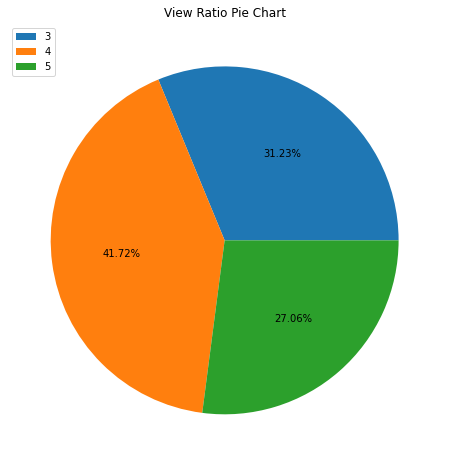

In [39]:
# 파이 차트 그리기
plt.figure(figsize=(8,8))
plt.pie(ratio_list, autopct='%.2f%%')
plt.title('View Ratio Pie Chart')
plt.legend(view_counts)
plt.show()

### STEP 4. CSR matrix를 직접 만들어 봅시다.

`CSR(Compressed Sparse Row) Matrix`: 몇백GB나 되는 거대한 행렬을 메모리에 올려놓고 작업한다는 것은 불가능 함. 이 때 사용되는 것이 CSR

In [40]:
# 참고. https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
from scipy.sparse import csr_matrix

num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()

csr_data = csr_matrix((ratings.counts, (ratings.user_id, ratings.movie_id)), shape= (num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

In [41]:
csr_data.shape

(6040, 3628)

### STEP 5. als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시켜 봅시다.


Matrix Factorization 모델을 implicit 패키지를 사용하여 학습.
* `implicit` 패키지는 암묵적(implicit) dataset을 사용하는 다양한 모델을 굉장히 빠르게 학습할 수 있는 패키지.
* 이 패키지에 구현된 `als(AlternatingLeastSquares) 모델`을 사용.
* `Matrix Factorization`에서 쪼개진 두 Feature Matrix를 한꺼번에 훈련하는 것은 잘 수렴하지 않기 때문에, 한쪽을 고정시키고 다른 쪽을 학습하는 방식을 번갈아 수행하는 AlternatingLeastSquares 방식이 효과적인 것으로 알려져 있음.

- [AlternatingLeastSquares](https://implicit.readthedocs.io/en/latest/als.html) 클래스의 `__init__` 파라미터
    - factors (int, optional): 유저와 아이템의 벡터를 몇 차원으로 할 것인지
    - regularization (float, optional): 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
    - dtype (data-type, optional)
    - use_native (bool, optional)
    - use_cg (bool, optional)
    - use_gpu (bool, optional): GPU를 사용할 것인지
    - iterations (int, optional): epochs와 같은 의미. 데이터를 몇 번 반복해서 학습할 것인지
    - calculate_training_loss (bool, optional)
    - num_threads (int, optional)
    - random_state (int, RandomState or None, optional)
- 1번 factors 와 7번 iterations 를 늘릴수록 학습 데이터를 잘 학습하게 되지만 과적합의 우려가 있으니 좋은 값을 찾아야 함!
    - factors=300, iterations=15 으로 진행
- **cf. 패키지 설치 참고: 최신 implicit 패키지 버전 0.5.2 로 사용하면 에러가 발생하므로 삭제하고 lms 클라우드와 동일한 0.4.8 버전으로 설치해야 함!!!**

```bash
# implicit 패키지 버전 0.4.8로 설치해야 에러가 발생하지 않음!
pip install implicit==0.4.8

# 아나콘다 사용자일 경우 implicit 0.4.8 버전 설치 코드
conda install -c conda-forge implicit==0.4.8
```

In [47]:
%%capture
pip install implicit==0.4.8

In [48]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분. 학습 내용과는 무관.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [49]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=300, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [50]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줌.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [51]:
csr_data_transpose.shape

(3628, 6040)

In [52]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

### STEP 6. 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요.

In [53]:
user = user_to_idx[6041]
user_vector = als_model.user_factors[user]
user_vector  # 사용자 벡터

array([ 1.10820852e-01,  4.00224686e-01, -6.76002502e-01, -2.58633226e-01,
        7.09861517e-01, -1.81069314e-01, -1.95618778e-01, -3.44355822e-01,
       -1.29528090e-01,  3.95882696e-01,  4.97596003e-02,  6.57548368e-01,
        1.71721086e-01, -1.39136270e-01,  1.50165901e-01, -1.58141509e-01,
       -1.27789900e-01,  6.07860625e-01, -2.28692010e-01,  1.36964664e-01,
        5.14381751e-03, -5.91402352e-01,  2.67577648e-01, -6.37086511e-01,
        3.06093305e-01, -1.23134263e-01,  3.46058309e-01, -7.80397356e-01,
       -6.27603710e-01, -9.67190266e-02,  5.95597386e-01,  2.85602212e-01,
       -2.91682184e-01,  5.94458580e-01, -4.32348192e-01,  6.31671667e-01,
        3.29600066e-01,  3.48850012e-01, -2.30811000e-01, -7.42425174e-02,
        1.86990425e-01,  1.48280337e-01,  3.26159745e-01, -2.08325848e-01,
        1.12432368e-01, -1.11799695e-01,  6.62484527e-01,  1.97728321e-01,
       -1.46292195e-01,  5.62058210e-01,  2.44593799e-01, -3.97472650e-01,
       -1.53948352e-01, -

In [54]:
star_wars_epi_4 = movie_to_idx['Star Wars: Episode IV - A New Hope (1977)']
star_wars_epi_4_vector = als_model.item_factors[star_wars_epi_4]
star_wars_epi_4_vector  # 영화 벡터

array([ 1.17532851e-03,  2.17094249e-03, -1.42105506e-03, -1.39758247e-03,
       -1.27033442e-02,  8.19418207e-03,  2.41962005e-03,  4.31589969e-02,
        2.46197376e-02,  1.01002930e-02,  1.68264005e-02, -8.44115671e-03,
        1.88799351e-02, -1.23900669e-02, -2.48289783e-03,  1.36335036e-02,
       -1.59284135e-03,  8.04718118e-03,  2.39292029e-02, -1.19142933e-02,
        1.97893754e-02,  1.43881766e-02, -2.62265485e-02, -5.31291449e-03,
        1.02570653e-02, -6.49892399e-03,  2.34350767e-02,  1.85987912e-02,
       -1.89328119e-02,  2.97145476e-03, -2.18295567e-02, -2.84722284e-03,
        1.76307447e-02,  1.94876939e-02,  1.31566674e-02,  1.03850625e-02,
       -2.20621321e-02, -9.58910678e-03,  1.10263797e-03,  2.88319518e-03,
       -2.17846986e-02,  1.18098753e-02, -4.46446269e-04,  4.27846062e-05,
       -5.11205988e-04,  2.38633249e-02,  1.74674932e-02,  9.70508903e-03,
        1.06240707e-02,  5.26462542e-03, -8.61514639e-03, -1.54079916e-02,
       -7.60727981e-03,  

In [55]:
# user와 star_wars_epi_4를 내적하는 코드
np.dot(user_vector, star_wars_epi_4_vector)

-0.011350354

In [56]:
toy_story_2 = movie_to_idx['Toy Story 2 (1999)']
toy_story_2_vector = als_model.item_factors[toy_story_2]
np.dot(user_vector, toy_story_2_vector)

-0.049853012

In [57]:
def predict_my_preference(user_vector, title, print_flag=True):
    movie = movie_to_idx.get(title, 0)
    movie_vector = als_model.item_factors[movie]

    # user_vector와 movie_vector를 내적하는 코드
    dot_user_movie = np.dot(user_vector, movie_vector)
    if print_flag:
        print(f'* user_vector 와 movie_vector({title}) 를 내적한 결과: {dot_user_movie:.2f}')
    else:
        return round(dot_user_movie, 2)

In [58]:
predict_my_preference(user_vector, 'Toy Story 2 (1999)')

* user_vector 와 movie_vector(Toy Story 2 (1999)) 를 내적한 결과: -0.05


In [59]:
for movie_id, movie_title in my_favorite.items():
    predict_my_preference(user_vector, movie_title)

* user_vector 와 movie_vector(From Dusk Till Dawn (1996)) 를 내적한 결과: 0.50
* user_vector 와 movie_vector(Devil in a Blue Dress (1995)) 를 내적한 결과: 0.50
* user_vector 와 movie_vector(Professional, The (a.k.a. Leon: The Professional) (1994)) 를 내적한 결과: 0.69
* user_vector 와 movie_vector(Body Snatchers (1993)) 를 내적한 결과: 0.36
* user_vector 와 movie_vector(Jacob's Ladder (1990)) 를 내적한 결과: 0.64


- 영화 데이터에 선호도 컬럼 추가

In [60]:
my_prefer = []
for title in movies['title'].to_list():
    my_prefer.append(predict_my_preference(user_vector, title, False))

In [61]:
movies.insert(len(movies.columns), 'my_prefer', my_prefer, allow_duplicates=True)
movies

,movie_id,title,genre,my_prefer
0,1,Toy Story (1995),Animation|Children's|Comedy,-0.06
1,2,Jumanji (1995),Adventure|Children's|Fantasy,0.01
2,3,Grumpier Old Men (1995),Comedy|Romance,0.02
3,4,Waiting to Exhale (1995),Comedy|Drama,0.07
4,5,Father of the Bride Part II (1995),Comedy,0.00
...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,-0.03
3879,3949,Requiem for a Dream (2000),Drama,-0.05
3880,3950,Tigerland (2000),Drama,-0.02
3881,3951,Two Family House (2000),Drama,-0.01


- 선호도 0.6 이상인 영화 목록

In [62]:
movies[movies['my_prefer'] >= 0.6]

,movie_id,title,genre,my_prefer
290,293,"Professional, The (a.k.a. Leon: The Profession...",Crime|Drama|Romance|Thriller,0.69
3407,3476,Jacob's Ladder (1990),Horror|Mystery|Thriller,0.64


### STEP 7. 내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다.

In [63]:
favorite_movie = 'Heavenly Creatures (1994)'
movie_title = movie_to_idx[favorite_movie]
similar_movies = als_model.similar_items(movie_title, N=15)
similar_movies

[(868, 1.0),
 (2415, 0.472307),
 (230, 0.4637773),
 (2886, 0.4632165),
 (274, 0.46287814),
 (313, 0.46152514),
 (3485, 0.4588089),
 (2926, 0.45872182),
 (2552, 0.457757),
 (3217, 0.45714074),
 (1768, 0.45552337),
 (3309, 0.45499146),
 (3093, 0.45305136),
 (2894, 0.45195386),
 (3278, 0.45098925)]

In [64]:
# movie_to_idx 를 뒤집어, index로부터 movie 이름을 얻는 dict를 생성. 
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
[idx_to_movie[i[0]] for i in similar_movies]

['Heavenly Creatures (1994)',
 'Trust (1990)',
 'Death and the Maiden (1994)',
 'New Age, The (1994)',
 'All Over Me (1997)',
 'Nowhere (1997)',
 'Return with Honor (1998)',
 'Kronos (1973)',
 'Normal Life (1996)',
 'Zed & Two Noughts, A (1985)',
 'Naked (1993)',
 'Hollow Reed (1996)',
 'Rough Magic (1995)',
 'When Night Is Falling (1995)',
 'Head On (1998)']

In [65]:
def get_similar_movie(movie_name: str):
    movie_title = movie_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_title, N=15)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movies]
    return similar_movie

print("슝=3")

슝=3


In [66]:
get_similar_movie('Deep Impact (1998)')

['Heavenly Creatures (1994)',
 'Trust (1990)',
 'Death and the Maiden (1994)',
 'New Age, The (1994)',
 'All Over Me (1997)',
 'Nowhere (1997)',
 'Return with Honor (1998)',
 'Kronos (1973)',
 'Normal Life (1996)',
 'Zed & Two Noughts, A (1985)',
 'Naked (1993)',
 'Hollow Reed (1996)',
 'Rough Magic (1995)',
 'When Night Is Falling (1995)',
 'Head On (1998)']

### STEP 8. 내가 가장 좋아할 만한 영화들을 추천받아 봅시다.

In [67]:
user = user_to_idx[6041]
# recommend에서는 user*item CSR Matrix를 받음.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(831, 0.25006637),
 (855, 0.24911684),
 (289, 0.19971344),
 (1113, 0.18738139),
 (440, 0.1818425),
 (624, 0.15843472),
 (1368, 0.14959289),
 (1090, 0.14904927),
 (201, 0.14749816),
 (1107, 0.14649558),
 (299, 0.14341643),
 (1486, 0.14197043),
 (250, 0.14103746),
 (174, 0.13857098),
 (456, 0.1377738),
 (924, 0.13767233),
 (242, 0.13491711),
 (467, 0.13441774),
 (51, 0.13412654),
 (997, 0.13202858)]

In [68]:
[idx_to_movie[i[0]] for i in movie_recommended]

["Devil's Advocate, The (1997)",
 'Grifters, The (1990)',
 'Reservoir Dogs (1992)',
 'Dead Again (1991)',
 'True Romance (1993)',
 'Naked Gun 33 1/3: The Final Insult (1994)',
 'Henry: Portrait of a Serial Killer (1990)',
 'Nikita (La Femme Nikita) (1990)',
 'Who Framed Roger Rabbit? (1988)',
 "Rosemary's Baby (1968)",
 'Mariachi, El (1992)',
 'Angel Heart (1987)',
 'Edward Scissorhands (1990)',
 'Blade (1998)',
 'Arachnophobia (1990)',
 'Dark City (1998)',
 'Out of Sight (1998)',
 'Cape Fear (1991)',
 'Fargo (1996)',
 'Scream (1996)']

In [69]:
item_movie = movie_to_idx['Kansas City (1996)']
explain = als_model.explain(user, csr_data, itemid=item_movie)

In [70]:
[(idx_to_movie[i[0]], i[1]) for i in explain[1]]

[('Devil in a Blue Dress (1995)', 0.012322104760172693),
 ('From Dusk Till Dawn (1996)', 0.008194384720186994),
 ('Body Snatchers (1993)', 0.005925320757150266),
 ("Jacob's Ladder (1990)", 0.0008447384117465576),
 ('Professional, The (a.k.a. Leon: The Professional) (1994)',
  -0.005346518680694664)]

---

### 루브릭.

|평가문항|비고|상세기준|비고 |
|:---|:---:|:---|---:|
|CSR matrix가 정상적으로 만들어졌다. | |사용자와 아이템 개수를 바탕으로 정확한 사이즈로 만들었다. | |
|MF 모델이 정상적으로 훈련되어 그럴듯한 추천이 이루어졌다. | |사용자와 아이템 벡터 내적수치가 의미있게 형성되었다. | |
|비슷한 영화 찾기와 유저에게 추천하기의 과정이 정상적으로 진행되었다. | |MF모델이 예측한 유저 선호도 및 아이템간 유사도, 기여도가 의미있게 측정되었다. | |

---

### 회고록.

추천 시스템의 개념과 목적을 이해해 Implicit 라이브러리를 활용하여 Matrix Factorization 기반의 추천 모델을 CSR matrix를 이용해 만들어 나의 취향을 분석해 추천 영화 목록을 만들어보는 15번째 exp 프로젝트였다.  
implicit 라이브러리 버전이 달라 실행이 되지 않았을 때 스트레스를 받았다.
다행히도 search를 통해 방법을 찾아 진행할 수 있었다.  
이번 프로젝트는 벡터 개념때문인지 유독 더 이해하기 어려웠다.  
추천시스템은 많은 분야에서 활용될수 있음에도 정작 그 구조를 이해하지 못하고 있다는 점이 굉장히 분했다.
중간중간 수학적인 부분을 진행할때마다 굉장히 벅찬데 이 부분을 빠른시일내에 해결할 필요가 있음.
추천시스템의 원리인 벡터 개념을 좀 더 이해할 필요가 있음.


---

### Reference. (APA)



콘텐츠 추천 알고리즘의 진화.(2022).(http://dl.moazine.com/viewer/index.asp?libraryid=9MtJb2T3nzH3yk7c212iu821DPFsY2ECOso0&a_i=8wwot4affaz3r6syx11VOYm2&keyword=&s_i=9#page/2)  

Last.fm Dataset - 360K users.(2022).(http://ocelma.net/MusicRecommendationDataset/lastfm-360K.html)  

Matrix Factorization.(2022).(https://developers.google.com/machine-learning/recommendation/collaborative/matrix)  

CuMF_SGD: Fast and Scalable Matrix Factorization.(2022).(https://arxiv.org/pdf/1610.05838.pdf)  

Collaborative Filtering for Implicit Feedback Datasets.(2022).(http://yifanhu.net/PUB/cf.pdf)  

Recommender System — Matrix Factorization.(2022).(https://towardsdatascience.com/recommendation-system-matrix-factorization-d61978660b4b)  

'scipy.sparse.csr_matrix'.(2022).(https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html)  

github_implicit.(2022).(https://github.com/benfred/implicit)   

implicit 0.4.8.(2022).(https://implicit.readthedocs.io/en/latest/)  

위키피디아 희소행렬.(2022).(https://ko.wikipedia.org/wiki/%ED%9D%AC%EC%86%8C%ED%96%89%EB%A0%AC)  

갈아먹는 추천 알고리즘 [1] 추천 알고리즘의 종류
.(2022).(https://yeomko.tistory.com/3)  





---